In [140]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [141]:
#params = Table.read('line_fit_params.ecsv')
#20191030 modifying for new fits
params = Table.read('emmision_lines_for.model.ecsv')

In [142]:
a, m, s, o= params['Amplitude'], params['Mean'], params['Stddev'], params['Offset']
mask = a > 0
a, m, s = a[mask], m[mask], s[mask]
a += -1*o

In [143]:
for i in range(len(a)):
    if i == 0:
        lines_mod = models.Gaussian1D(a[i], m[i], s[i])
    else:
        lines_mod = lines_mod + models.Gaussian1D(a[i], m[i], s[i])

In [144]:
#seperate ciii1176 lines
params = Table.read('ciii1176_lines_for.model.ecsv')
a, m, s, o= params['Amplitude'], params['Mean'], params['Stddev'], params['Offset']
mask = a > 0
a, m, s, o = a[mask], m[mask], s[mask], o[mask]
a += -1*o

for i in range(len(a)):
    lines_mod = lines_mod + models.Gaussian1D(a[i], m[i], s[i])

In [145]:
params = Table.read('ca_emmision_lines_for.model.ecsv')
a, m, s, o= params['Amplitude'], params['Mean'], params['Stddev'], params['Offset']
mask = a > 0
a, m, s, o = a[mask], m[mask], s[mask], o[mask]
a += -1*o

#for i in range(len(a)):
lines_mod = lines_mod + models.Gaussian1D(a[0], m[0], s[0]) #2nd line is an upper limit

In [146]:
mw = np.arange(1000, 4200, 0.01)

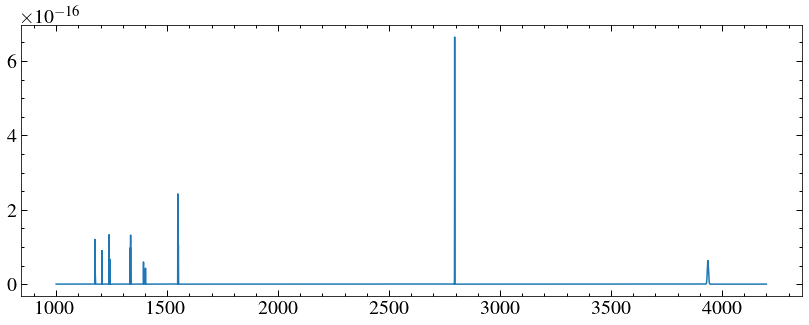

In [147]:
plt.plot(mw, lines_mod(mw))
mf = lines_mod(mw)
#plt.xlim(1170, 1180)

Yay!

In [148]:
#hdul = fits.open('../dem/trappist-1_dem_spectra.fits')
hdul = fits.open('../dem/spectrum_trappist_one_d13.fits')

In [149]:
hdul.info()

Filename: ../dem/spectrum_trappist_one_d13.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     20   3805R x 4C   [D, D, D, D]   


In [150]:
data = hdul[1].data
data.names

['Wavelength', 'Flux_density', 'Lower_Error_16', 'Upper_Error_84']

In [151]:
#w, f, e = data['Wavelength'], data['Bin-Integrated Flux'], data['Error']
w, f, bin_el, bin_eu = data['Wavelength'], data['Flux_density'], data['Lower_Error_16'], data['Upper_Error_84']

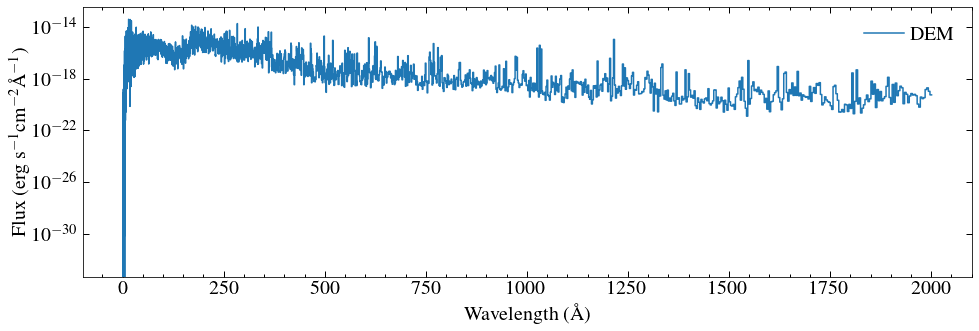

In [152]:
#plt.figure(figsize=(8,5))
plt.step(w,f, label = 'DEM')
#plt.plot(mw, lines_mod(mw), label ='Fit')
#plt.ylim(-0.1e-15, 0.4e-15)
#plt.xlim(1170.1, 1179.9)
#plt.xlim(1190, 1210)
plt.legend()
plt.axhline(0, ls='--', c='k')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.yscale('log')
plt.tight_layout()
#plt.savefig('mod_eg.png', dpi=150)


In [153]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff = np.concatenate((np.array([diff[0]]), diff)) #adds an extra value to make len(diff) = len(w)
    w0 = w - diff/2.
    w1 = w + diff/2.
    return w0, w1


In [154]:
w0, w1 = wavelength_edges(w)

In [155]:
euv = Table.read('../combined/TRAPPIST-1_1Aeuv_estimate.ecsv')

In [156]:
linw, linf = euv['WAVELENGTH'], euv['FLUX']

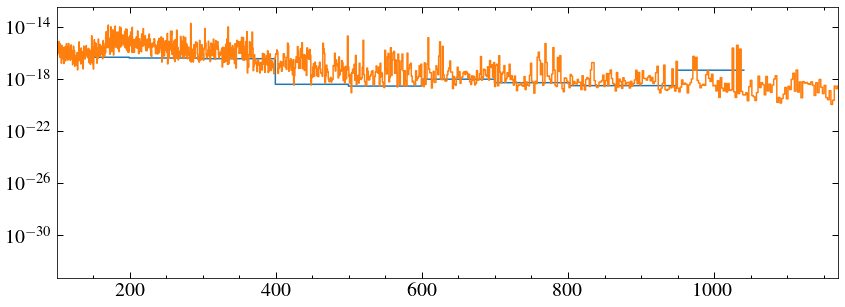

In [157]:
plt.step(linw, linf)
plt.step(w,f)
plt.xlim(linw[0], linw[-1])#
#plt.ylim(, 1e-15)
plt.yscale('log')

So comparable.

What does the dem look like compared with Phoenix?

(2000, 4000)

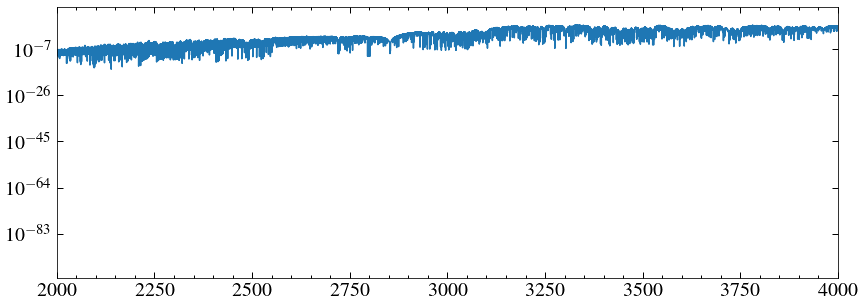

In [158]:
#pmod = Table.read('../phoenix_repo/phoenix_interpolated.ecsv')
pmod = Table.read('../optical/lyon_phoenix_2628_5.21_100um.ecsv')
plt.plot(pmod['WAVELENGTH'], pmod['FLUX'])
plt.yscale('log')
plt.xlim(2000, 4000)

In [159]:
pw, pf = pmod['WAVELENGTH'], pmod['FLUX']*4.67506360740083e-20

In [160]:
#stis_opt = 'odlm41010_sx1.fits'
#data = fits.getdata('../combined/'+stis_opt,1)[0]
data = Table.read('../optical/t1_g430m_edit.ecsv')
wo = data['WAVELENGTH']#[dt['DQ']==0]
fo = data['FLUX']#[dt['DQ']==0]
#mask = (wo > 4500) & (wo < 5321) | (wo > 5325) & (wo < 5476.5) | (wo > 5480.5) #cutting out overlap and cosmics
#wo, fo = wo[mask], fo[mask]

/home/david/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


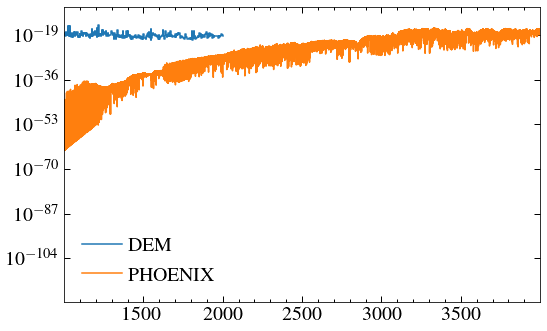

In [161]:
plt.figure(figsize=(8,5))
plt.step(w,f, where='mid', label='DEM')
plt.plot(pw, pf, label='PHOENIX')
#plt.step(wo, fo)
plt.yscale('log')
plt.xlim(1001,3999)
plt.tight_layout()
plt.legend()
#plt.savefig('DEMvPHOENIX.png', dpi=150)

So we have a gap.

Can I interpolate onto a 1A grid using scipy? Craftroom didn't work

In [162]:
f1 = interp1d(w, f, fill_value='extrapolate', kind='nearest')(w1)
f_add = f1
f_mod = lines_mod(w1)
for i in range(len(w1)):
    if f_mod[i] > 0.0:
        f_add[i] = 0
f_add += f_mod
        

(1190, 1210)

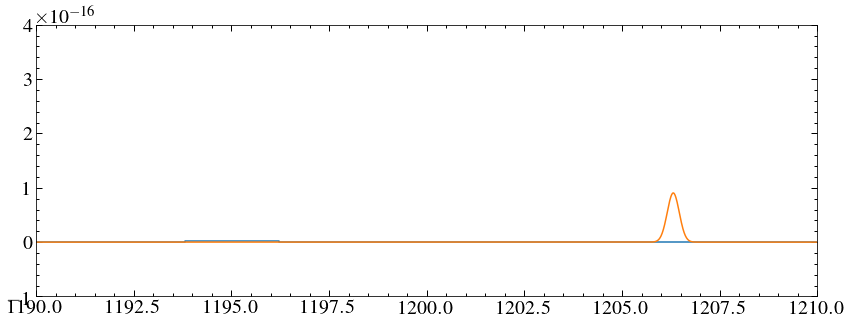

In [163]:
plt.step(w1, f_add)
plt.plot(mw, lines_mod(mw))

plt.ylim(-0.1e-15, 0.4e-15)
#plt.xlim(1170.1, 1179.9)
plt.xlim(1190, 1210)

In [164]:
hdul = fits.open('../xmm/Trappist-1.fits')

In [165]:
data = hdul[1].data
mdata = hdul[2].data

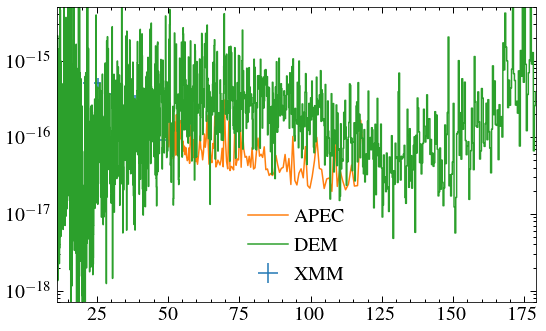

In [166]:
plt.figure(figsize=(8,5))
plt.errorbar(data['WAVE'], data['CFlux'], xerr=data['BIN_WIDTH']/2, yerr = data['CFLUX_err'], ls ='none', label='XMM')
#plt.step(data['WAVE'], data['CFlux'], where='mid', label ='XMM')
mask = mdata['WAVE'] > data['WAVE'][-1]
plt.plot(mdata['WAVE'][mask], mdata['FLUX'][mask], label='APEC')
plt.step(w,f, where='mid', label='DEM')
plt.ylim(7e-19, 5e-15)
plt.xlim(11, 179)
plt.yscale('log')
plt.legend()
plt.tight_layout()
#plt.savefig('DEMvXMM.png', dpi=150)

In [167]:
#plt.plot(w,f)
g130m = fits.getdata('../COS/test_files/hlsp_muscles_hst_cos_2mass-j23062928-0502285_g130m_v1_component-spec.fits',1)

from astropy.convolution import convolve, Box1DKernel


20190724 What if we fit a curve to the DEM, then added lines to that?

In [168]:
from astropy.modeling import models, fitting
fitter = fitting.LinearLSQFitter()
n_init = models.Polynomial1D(4)

In [169]:
mask = w >1000

nfit = fitter(n_init, w[mask],np.log10(f[mask]))

 [astropy.modeling.fitting]


In [170]:
nfit

<Polynomial1D(4, c0=-26.12701813, c1=0.01966928, c2=-0.00001598, c3=0., c4=0.)>

(1001, 3999)

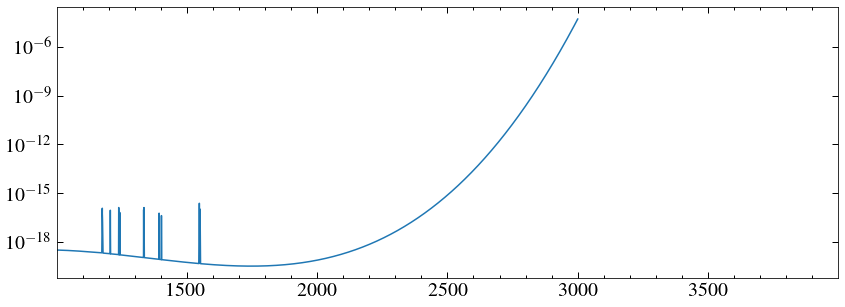

In [171]:
overlap_mask = (pw >=1000) & (pw <= 3000)
overlap_model = lines_mod(pw[overlap_mask]) + 10**nfit(pw[overlap_mask])
overlap_w, overlap_p = pw[overlap_mask], pf[overlap_mask]
combined = overlap_model+overlap_p
plt.plot(overlap_w, combined)
#plt.plot(pw, pf, label='PHOENIX', zorder=-1)
plt.yscale('log')
plt.xlim(1001,3999)

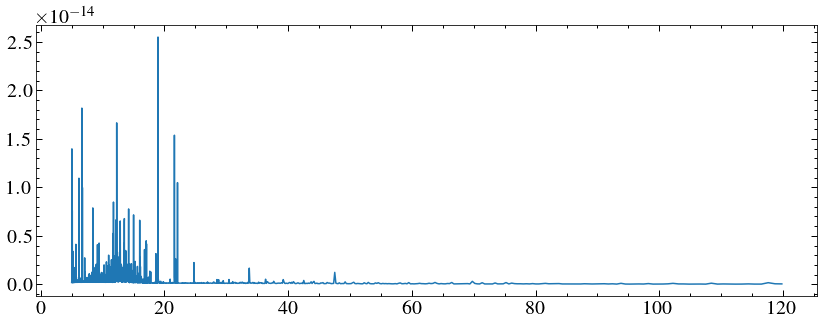

In [172]:
#apec 
apec = fits.getdata('../xmm/Trappist-1.fits',2)
plt.plot(apec['Wave'], apec['FLUX'])

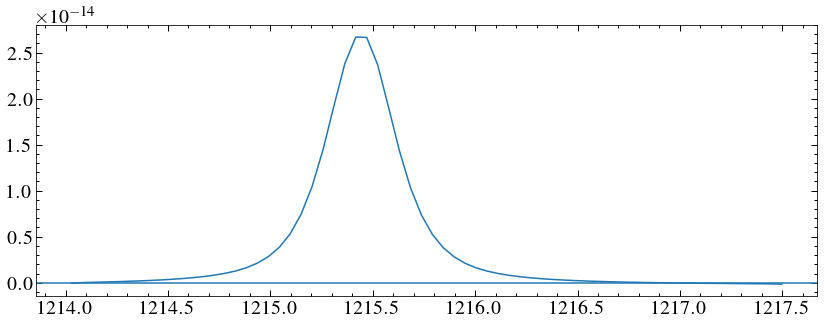

In [173]:
lya = Table.read('../lya/Trappist-1_lya_simple.txt', format='ascii')
plt.plot(lya['WAVELENGTH'], lya['FLUX'])
lyaw, lyaf = lya['WAVELENGTH'][lya['FLUX'] > 0], lya['FLUX'][lya['FLUX'] > 0] 
plt.axhline(0)

(90, 10000)

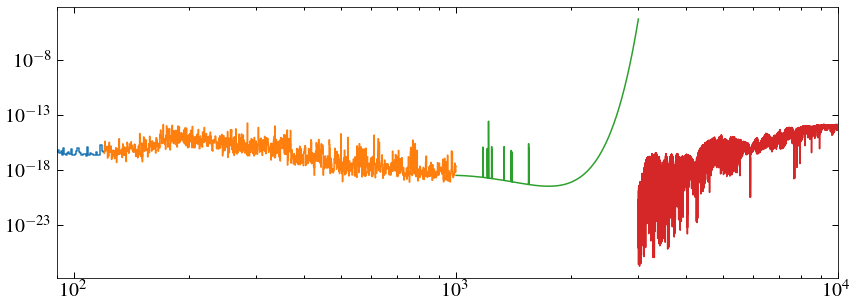

In [174]:
plt.step(apec['Wave'], apec['FLUX'], where='mid')
dem_mask = (w > apec['Wave'][-1]) & (w < 1000)
plt.step(w[dem_mask], f[dem_mask], where='mid')
#lya_mask = (overlap_w < lyaw[0]) | (overlap_w > lyaw[-1])
#plt.plot(overlap_w[lya_mask], combined[lya_mask])
lya_f_new = interp1d(lyaw, lyaf, bounds_error=False, fill_value=0)(overlap_w)
plt.plot(overlap_w, combined+lya_f_new)
#plt.plot(lyaw, lyaf)
p_mask = pw > 3000
plt.plot(pw[p_mask], pf[p_mask])
#plt.plot(w,f, zorder=-5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(90, 10000)

(-1e-16, 1e-15)

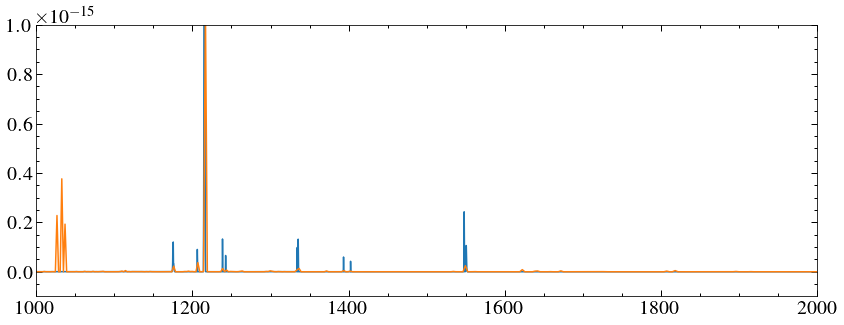

In [175]:
plt.plot(overlap_w, combined+lya_f_new)
plt.plot(w,f)
plt.xlim(1000, 2000)
plt.ylim(-1e-16, 1e-15)

What about the STIS CCD spectrum for the gap?

In [210]:
#ccd = '/home/david/work/muscles/trappist-1/hst/stis_collection/odlm41010_sx1.fits'
ccd = '../test_files/components/hlsp_muscles_hst_stis_2mass-j23062928-0502285_g430l_v5_component-spec.fits'
data = fits.getdata(ccd,1)


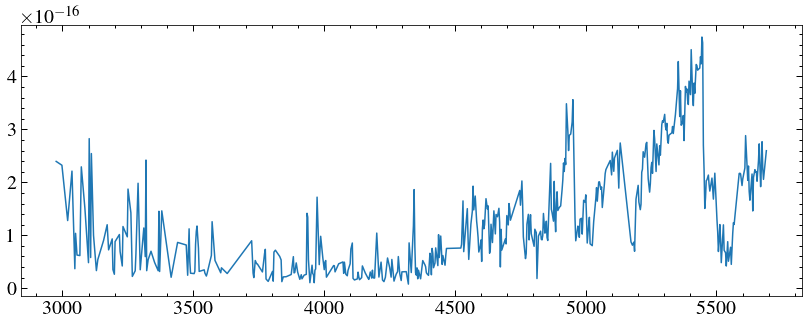

In [211]:
plt.plot(data['WAVELENGTH'], data['FLUX'])

/home/david/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


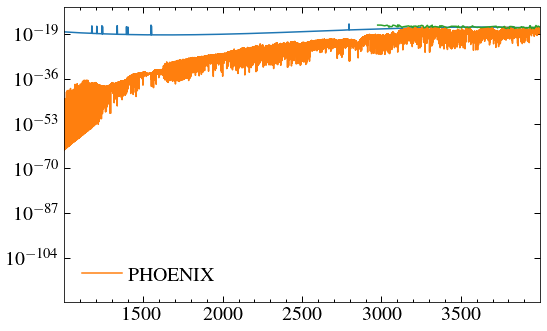

In [212]:
plt.figure(figsize=(8,5))
#plt.step(w,f/5, where='mid', label='DEM')
plt.plot(mw, lines_mod(mw)+10**nfit(mw))
plt.plot(pw, pf, label='PHOENIX')
plt.plot(data['WAVELENGTH'], data['FLUX'])
#plt.step(wo, fo)
plt.yscale('log')
plt.xlim(1001,3999)
plt.tight_layout()
plt.legend()

In [213]:
ws, fs, es, dqs= data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']


(0, 2.5e-16)

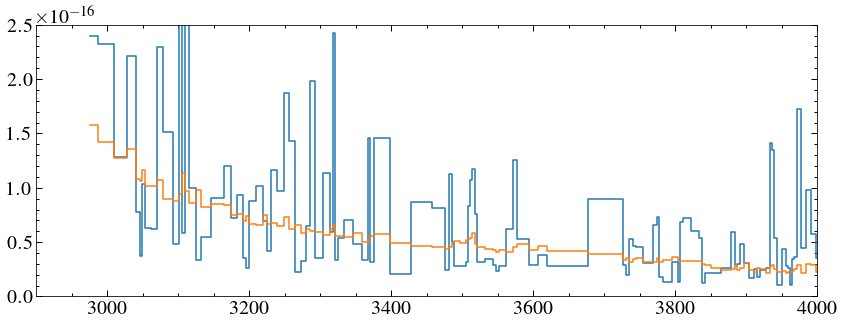

In [214]:
plt.step(ws[dqs==0],fs[dqs==0], where='mid')
plt.step(ws[dqs==0], es[dqs==0], where='mid')
plt.xlim(2900, 4000)
plt.ylim(0, 0.25e-15)

Ok looks reasonable- can we fit to that?

/home/david/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


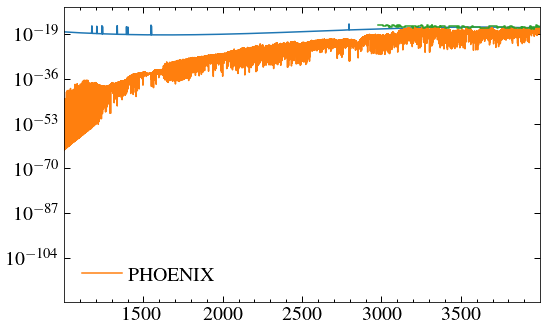

In [215]:
plt.figure(figsize=(8,5))
#plt.step(w,f/5, where='mid', label='DEM')
plt.plot(mw, lines_mod(mw)+10**nfit(mw))
plt.plot(pw, pf, label='PHOENIX')
plt.step(ws[dqs==0],fs[dqs==0], where='mid')
#plt.step(wo, fo)
plt.yscale('log')
plt.xlim(1001,3999)
plt.tight_layout()
plt.legend()

In [217]:
wclean, fclean = ws[dqs==0],fs[dqs==0]

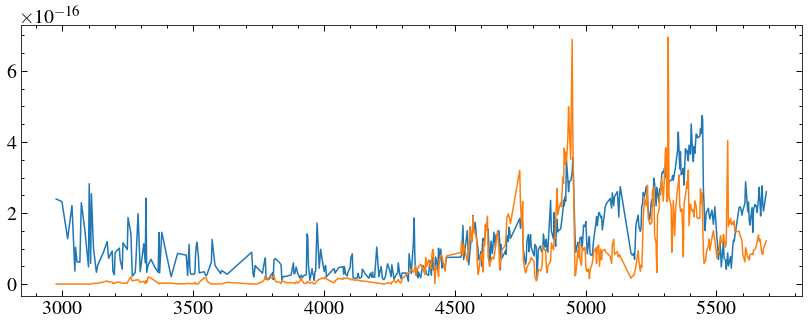

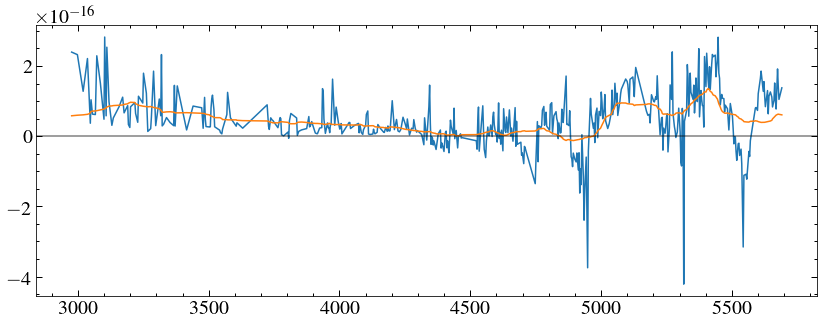

In [256]:
#remove phoenix model from stis spectrum before fitting
plt.plot(wclean, fclean)
pwo, pfo = resample.bintogrid(pw, pf, newx=wclean)
plt.plot(pwo, pfo)
plt.show()
plt.plot(pwo, fclean-pfo)
fsub = fclean-pfo
fsub = convolve(np.array(fsub),Box1DKernel(50))
plt.plot(wclean, fsub)
plt.axhline(0, c='k', alpha=0.5)

 [astropy.modeling.fitting]


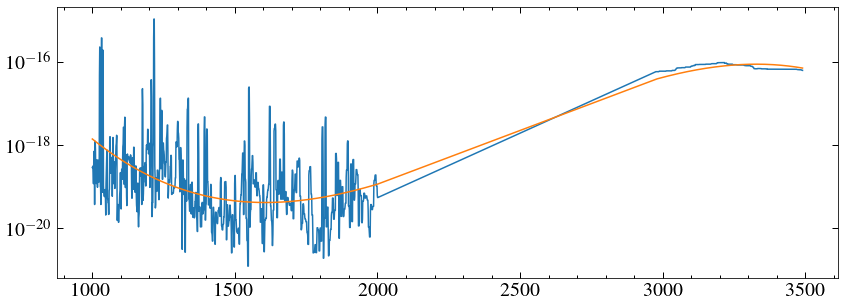

In [294]:
fitter = fitting.LinearLSQFitter()
#fitter = fitting.SLSQPLSQFitter()
#w, f, bin_el, bin_eu = data['Wavelength'], data['Bin-Integrated Flux'], data['Lower_Error_16'], data['Upper_Error_84']
mask1 = w > 1000
mask2 = (wclean < 3500) & (fsub > 0)

#nfit = fitter(n_init, w[mask],np.log10(f[mask]))

#w2fit, f2fit = np.concatenate((w[mask1], wclean[mask2])), np.concatenate((f[mask1], fsub[mask2]))
#w2fit, f2fit = resample.bintogrid(w2fit, f2fit, dx=1)
w11,  f11 = resample.bintogrid(w[mask1], f[mask1], dx=1)
w21, f21 = resample.bintogrid(wclean[mask2], fsub[mask2], dx=1)
w2fit, f2fit = np.concatenate((w11, w21)), np.concatenate((f11, f21))

#plt.plot(w2fit, f2fit)
#plt.yscale('log')
n_init = models.Polynomial1D(5)# + models.Polynomial1D(3)
nfit = fitter(n_init, w2fit,np.log10(f2fit))
#nfit = fitter(n_init, wclean[mask2],np.log10(fsub[mask2]))
plt.plot(w2fit, f2fit)
plt.plot(w2fit, 10**nfit(w2fit))
plt.yscale('log')
#nfit
#plt.xlim(3000, 4500)
#plt.ylim(1e-17, 1e-16)

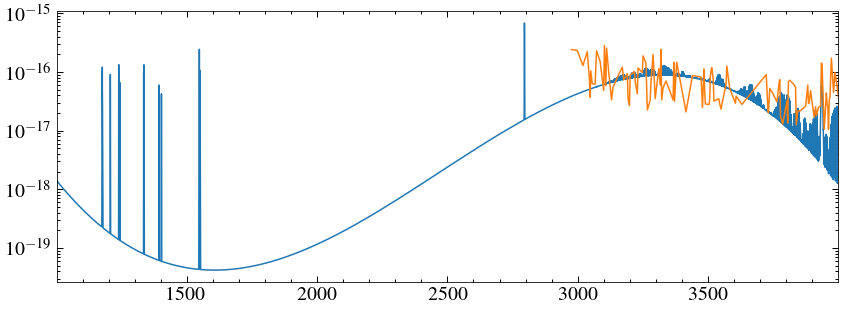

In [295]:
overlap_mask = (pw >=1000) & (pw <= 4000)
overlap_model = lines_mod(pw[overlap_mask]) + 10**nfit(pw[overlap_mask])
overlap_w, overlap_p = pw[overlap_mask], pf[overlap_mask]
combined = overlap_model+overlap_p
plt.plot(overlap_w, combined)
#plt.plot(pw, pf, label='PHOENIX', zorder=-1)
plt.yscale('log')
plt.xlim(1001,3999)
plt.plot(wclean, fclean)

(1e-23, 1e-11)

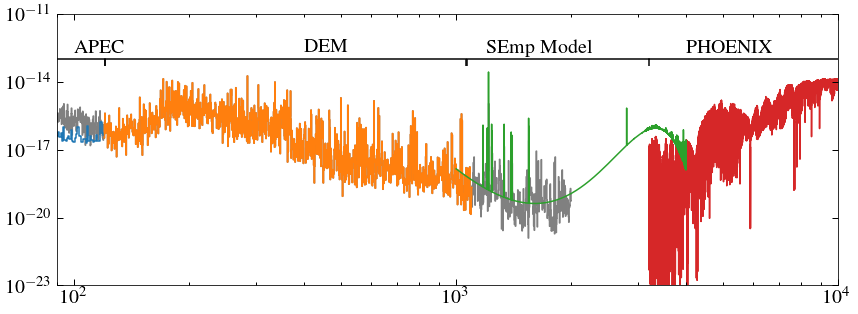

In [296]:
plt.step(apec['Wave'], apec['FLUX'], where='mid')
dem_mask = (w > apec['Wave'][-1]) & (w < 1100)
plt.step(w[dem_mask], f[dem_mask], where='mid')
#lya_mask = (overlap_w < lyaw[0]) | (overlap_w > lyaw[-1])
#plt.plot(overlap_w[lya_mask], combined[lya_mask])
lya_f_new = interp1d(lyaw, lyaf, bounds_error=False, fill_value=0)(overlap_w)
plt.plot(overlap_w, combined+lya_f_new)
#plt.plot(lyaw, lyaf)
p_mask = pw > 3200
plt.plot(pw[p_mask], pf[p_mask], zorder=-1)
plt.step(w,f, zorder=-5, c='0.5', where='mid')
plt.xscale('log')
plt.yscale('log')
plt.xlim(90, 10000)
#plt.errorbar((15,60),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
#plt.annotate('XMM', (20, 2e-13))

plt.errorbar((60,120),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
plt.annotate('APEC', (100, 2e-13))

plt.errorbar((120,1060),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
plt.annotate('DEM', (400, 2e-13))

plt.errorbar((1068, 3200),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
plt.annotate('SEmp Model', (1200, 2e-13))

plt.errorbar((3200, 54963),(1e-13, 1e-13), yerr= [[0,5e-14],[0,0]], c ='k')
plt.annotate('PHOENIX', (4000, 2e-13))

plt.ylim(1e-23, 1e-11)
#plt.plot(wclean, fclean)
#plt.savefig('SEmp_eg_w_comp.png', dpi= 150)

In [297]:
apec['WAVE'][-1]

119.8

Making a nice version for exoupdate

In [298]:
pw1, pf1 = resample.bintogrid(pw, pf, dx=1)

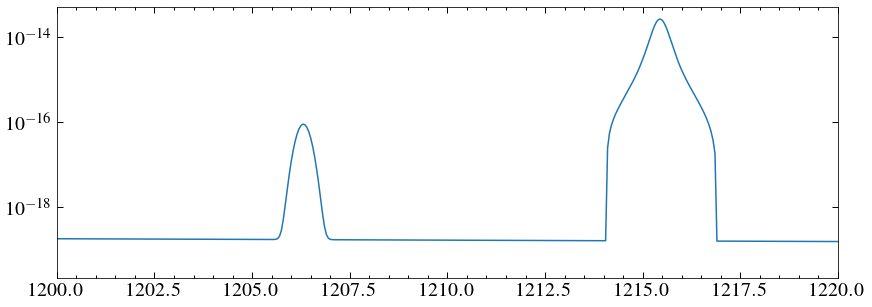

In [299]:
lya_f_new = interp1d(lyaw, lyaf, bounds_error=False, fill_value=0)(overlap_w)
sem_mask = overlap_w > 1100 
plt.plot(overlap_w[sem_mask], (combined+lya_f_new)[sem_mask])
plt.xlim(1200, 1220)
plt.yscale('log')

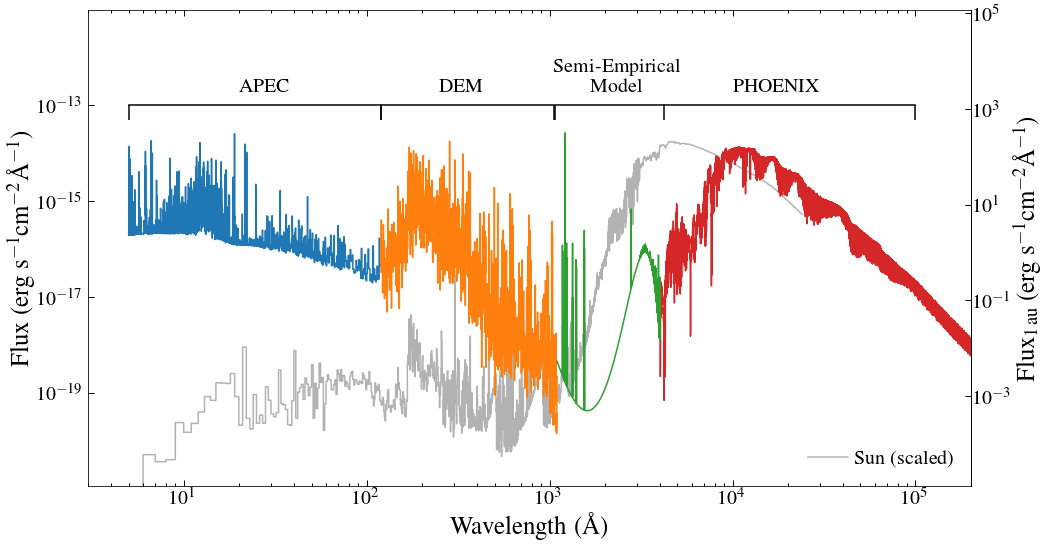

In [305]:
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
from matplotlib.transforms import Transform

fig, ax = plt.subplots(figsize=(15, 8))
plt.step(apec['Wave'], apec['FLUX'], where='mid')
dem_mask = (w > apec['Wave'][-1]) & (w < 1100)
plt.step(w[dem_mask], f[dem_mask], where='mid')
#lya_mask = (overlap_w < lyaw[0]) | (overlap_w > lyaw[-1])
#plt.plot(overlap_w[lya_mask], combined[lya_mask])
lya_f_new = interp1d(lyaw, lyaf, bounds_error=False, fill_value=0)(overlap_w)
sem_mask = overlap_w > 1100 
plt.plot(overlap_w[sem_mask], (combined+lya_f_new)[sem_mask])
#plt.plot(lyaw, lyaf)
p_mask = pw1 > 4000
plt.plot(pw1[p_mask], pf1[p_mask], zorder=-1)
#plt.step(w,f/5, zorder=-5, c='0.5', where='mid')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(90, 10000)
#plt.errorbar((15,60),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
#plt.annotate('XMM', (20, 2e-13))

plt.errorbar((5,120),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
plt.annotate('APEC', (20, 2e-13))

plt.errorbar((120,1060),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
plt.annotate('DEM', (250, 2e-13))

plt.errorbar((1068, 4200),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
plt.annotate('Semi-Empirical\n Model', (2300, 2e-13), ha='center')

plt.errorbar((4200, 100000),(1e-13, 1e-13), yerr= [[0,5e-14],[0,0]], c ='k')
plt.annotate('PHOENIX', (10000, 2e-13))

sol_spec =  readsav('../../../stuff/Solar-data.idlsav')
w_sol, f_sol = sol_spec['wave']*10, sol_spec['flux']*100
d_t1 = 12.1*u.pc 
d_sun = 1*u.au.to(u.pc)

#### scale by bolometric ps flux
r_t1 = 0.117*u.Rsun
#r_674 = 0.35*u.Rsun
t_t1= 2560*u.K
#t_674 = 3400*u.K
t_sun = 5777*u.k
bb_scale = (u.Rsun**2 * t_sun**4)/(r_t1**2 * t_t1**4)*(d_t1/d_sun)**2
plt.step(w_sol[w_sol>5], f_sol[w_sol>5]/bb_scale, zorder=-100, c='k', label = 'Sun (scaled)' , where='mid', alpha=0.3)

plt.ylim(1.1e-21, 9.9e-12)
plt.xlim(3, 2e5)
plt.xlabel('Wavelength (\AA)', size=25)
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)',size=25)
plt.legend(loc=4)

def t_to_s(x):
    return x*bb_scale.value

def s_to_t(x):
    return x/bb_scale.value

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False)      # ticks along the bottom edge are off   
secay = ax.secondary_yaxis('right', functions =(t_to_s, s_to_t))
#secay.yaxis.set_minor_locator(AutoMinorLocator())
secay.set_ylabel('Flux$_{\mathrm{ 1\,au}}$ (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size =25)


plt.tight_layout()
#plt.savefig('../plots/SEmp_v_sun.png', dpi= 150)
plt.savefig('../plots/new_SEmp_v_sun.pdf', dpi= 150)

Plots of components in the model.

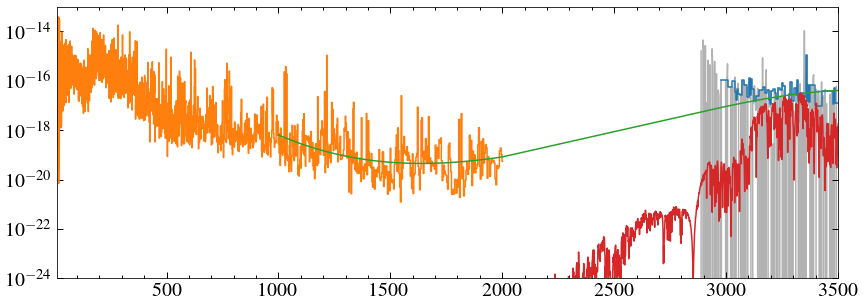

In [190]:
#plt.plot(w2fit, f2fit)
plt.step(wclean[mask2], fclean[mask2], where='mid')
plt.plot(ws, fs, zorder=-10, alpha=0.3, c='k')
plt.step(w[10:], (f)[10:], where='mid')
plt.plot(w2fit, 10**nfit(w2fit), )
plt.plot(pw1, pf1)
plt.ylim(1e-24, 1e-13)
plt.xlim(10, 3500)
plt.yscale('log')

#plt.xscale('log')

Building and saving the model. First let's get the 1A DEM.

In [191]:
def dem_to_1A(w,f):
    """
    Converts a DEM model at 5A resolution to 1A resolution
    """
    w1 = np.arange(w[0], w[-1], 1.)
    f1 = interp1d(w, f, fill_value='extrapolate', kind='nearest')(w1)
    return w1, f1

In [192]:
wd, fd = dem_to_1A(w,f)

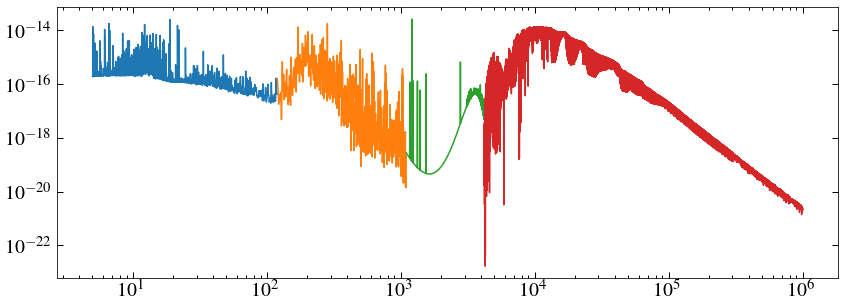

In [193]:
aw, af = apec['Wave'], apec['FLUX']
dem_mask = (wd > aw[-1]) & (wd < 1100)
dw, df = wd[dem_mask], (fd[dem_mask])
sem_mask = overlap_w > 1100 
semp_w, semp_f = overlap_w[sem_mask], (combined+lya_f_new)[sem_mask]

p_mask = pw >4200
pwm, pfm = pw[p_mask], pf[p_mask]
plt.plot(aw,af, dw, df, semp_w, semp_f, pwm, pfm)

plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-24, 1e-13)
#plt.xlim(10, 3500)

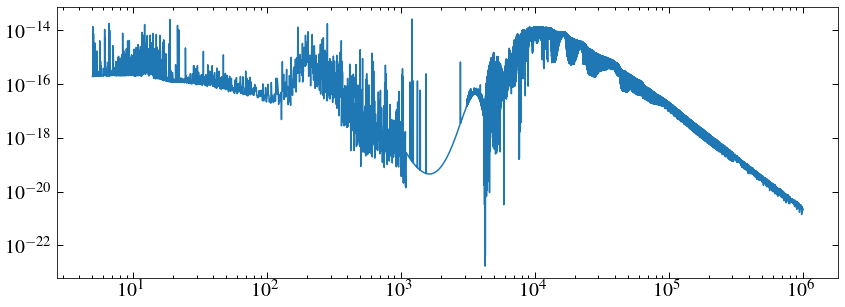

In [194]:
model_w = np.concatenate((aw, dw, semp_w, pwm))
model_f = np.concatenate((af, df, semp_f, pfm))
plt.plot(model_w, model_f)

plt.xscale('log')
plt.yscale('log')

1A model

In [195]:
model_w_1A, model_f_1A = resample.bintogrid(model_w, model_f, dx=1)

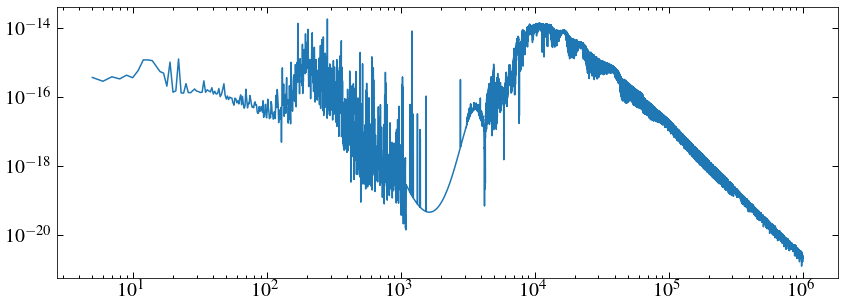

In [196]:
plt.plot(model_w_1A, model_f_1A)

plt.xscale('log')
plt.yscale('log')

Compare with SED 1A...

In [306]:
sed = Table.read('../../common/quicksaves/2MASS-J23062928-0502285_basic.ecsv')

In [307]:
sedw1A, sedf1A = resample.bintogrid(sed['WAVELENGTH'], sed['FLUX'], dx=1)

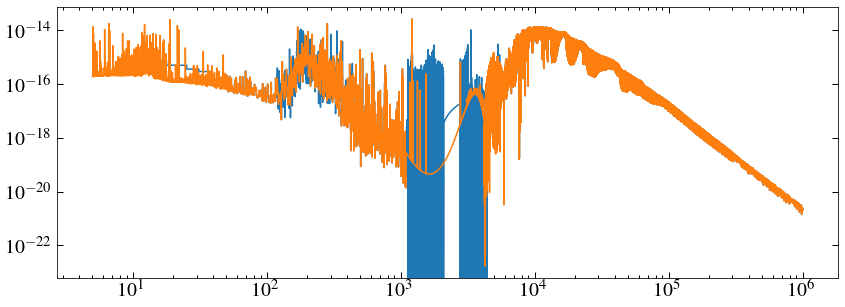

In [308]:
plt.step(sed['WAVELENGTH'], sed['FLUX'])
plt.step(model_w, model_f, zorder=2)
#plt.step(sedw1A[sedf1A > 0], sedf1A[sedf1A >0], where='mid')
#plt.step(model_w_1A, model_f_1A, where ='mid')


plt.xscale('log')
plt.yscale('log')

Why is the phoenix spectrum higher in the model? Phew- fixed- mix up over scalings.  

As I have all the bits here, making a new STIS v PHOENIX plot.

In [205]:
"""#plt.plot(w2fit, f2fit)
plt.figure(figsize=(8,6))
plt.step(pw, pf, label='PHOENIX', where='mid')
mask = (wclean <3355) | (wclean > 3365)
plt.step(wclean[mask], fclean[mask], where='mid', label='STIS G430L')
#plt.plot(ws, fs, zorder=-10, alpha=0.3, c='k')
#plt.plot(pw, pf)
#plt.ylim(1e-18, 1e-13)
plt.ylim(-0.09e-15, 0.69e-15)
plt.xlim(2900, 5700)
plt.legend()

plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.tight_layout()
#plt.xlim(3300, 3400)
#plt.yscale('log')
#plt.savefig('../plots/t1_phoenix_scaling.pdf', dpi=150)"""

"#plt.plot(w2fit, f2fit)\nplt.figure(figsize=(8,6))\nplt.step(pw, pf, label='PHOENIX', where='mid')\nmask = (wclean <3355) | (wclean > 3365)\nplt.step(wclean[mask], fclean[mask], where='mid', label='STIS G430L')\n#plt.plot(ws, fs, zorder=-10, alpha=0.3, c='k')\n#plt.plot(pw, pf)\n#plt.ylim(1e-18, 1e-13)\nplt.ylim(-0.09e-15, 0.69e-15)\nplt.xlim(2900, 5700)\nplt.legend()\n\nplt.xlabel('Wavelength (\\AA)')\nplt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\\AA$^{-1}$)')\nplt.tight_layout()\n#plt.xlim(3300, 3400)\n#plt.yscale('log')\n#plt.savefig('../plots/t1_phoenix_scaling.pdf', dpi=150)"

Saving the semi-empirical models.

In [201]:
savdat = Table([model_w, model_f], names=['WAVELENGTH', 'FLUX'])
ascii.write(savdat, 'saved_models/trappist-1_model_var_res_v06.ecsv', format='ecsv', overwrite=True)
savdat = Table([model_w_1A, model_f_1A], names=['WAVELENGTH', 'FLUX'])
ascii.write(savdat, 'saved_models/trappist-1_model_const_res_v06.ecsv', format='ecsv', overwrite=True)

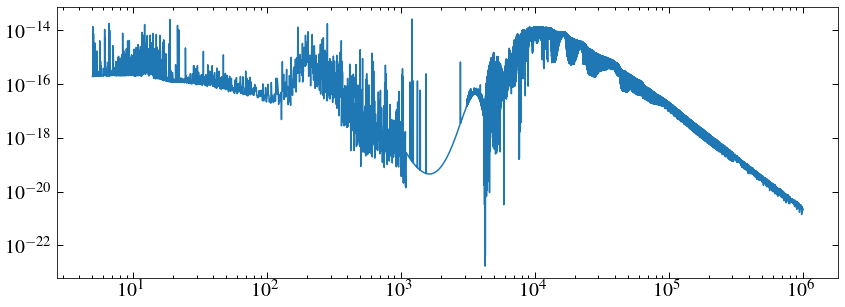

In [202]:
#check it worked
sep = Table.read('saved_models/trappist-1_model_var_res_v06.ecsv')
plt.plot(sep['WAVELENGTH'], sep['FLUX'])
plt.xscale('log')
plt.yscale('log')
#plt.xlim(3900, 4100)

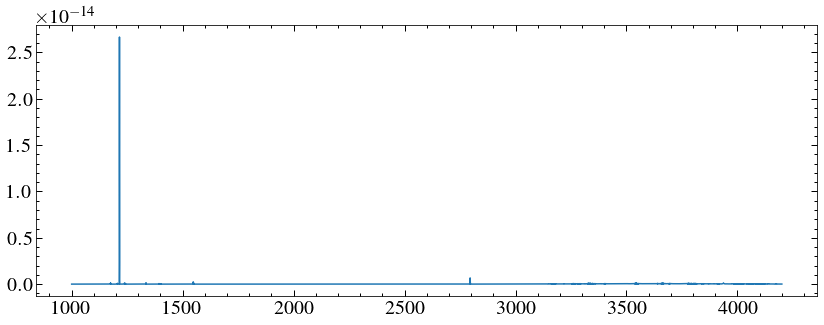

In [203]:
plt.plot(overlap_w, (combined+lya_f_new))


In [204]:
combined

6.433167456768496e-19
6.430258821511532e-19
6.427351784473439e-19
6.4244463446669e-19
6.4215425011052655e-19
6.4186402528025e-19
6.415739598773399e-19
6.412840538033158e-19
6.409943069597904e-19
6.407047192484274e-19
6.404152905709676e-19
